# EDA Project

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

In [2]:
# Creating database
engine = create_engine('sqlite:///mta_data.db')

In [3]:
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [4]:
mta_df = pd.read_sql('SELECT * FROM mta_data WHERE (DATE NOT like "02%") \
                         AND (("ENTRIES" IS NOT NULL) OR ("EXITS" IS NOT NULL));', engine)
mta_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,00:00:00,REGULAR,7107725,2407457
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,04:00:00,REGULAR,7107738,2407465
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,08:00:00,REGULAR,7107761,2407491
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,12:00:00,REGULAR,7107858,2407541
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,16:00:00,REGULAR,7108075,2407581
...,...,...,...,...,...,...,...,...,...,...,...
3506030,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/01/2019,04:00:00,REGULAR,5554,369
3506031,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/01/2019,08:00:00,REGULAR,5554,369
3506032,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/01/2019,12:00:00,REGULAR,5554,369
3506033,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/01/2019,16:00:00,REGULAR,5554,369


In [5]:
pd.read_sql('SELECT "STATION", COUNT(DISTINCT "LINENAME") AS COUNT_LINENAME FROM mta_data GROUP BY "STATION" \
            HAVING COUNT_LINENAME > 1;', engine)

,STATION,COUNT_LINENAME
0,103 ST,3
1,104 ST,2
2,111 ST,3
3,116 ST,3
4,125 ST,4
...,...,...
66,SPRING ST,2
67,TIMES SQ-42 ST,3
68,VAN SICLEN AV,2
69,WALL ST,2


## Data Cleaning

### Cleaning column names

In [6]:
mta_df.columns = [column.strip() for column in mta_df.columns]

In [7]:
mta_df.DATE.value_counts().sort_index()

03/01/2019    28691
03/02/2019    29234
03/03/2019    28836
03/04/2019    29067
03/05/2019    29234
              ...  
06/24/2019    29479
06/25/2019    29437
06/26/2019    29417
06/27/2019    29464
06/28/2019    29779
Name: DATE, Length: 120, dtype: int64

In [8]:
import datetime 

In [9]:
mta_df['DATE_TIME'] = pd.to_datetime(mta_df.DATE + ' ' + mta_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [10]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,00:00:00,REGULAR,7107725,2407457,2019-06-22 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,04:00:00,REGULAR,7107738,2407465,2019-06-22 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,08:00:00,REGULAR,7107761,2407491,2019-06-22 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,12:00:00,REGULAR,7107858,2407541,2019-06-22 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2019,16:00:00,REGULAR,7108075,2407581,2019-06-22 16:00:00


### Removing duplicates

In [11]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
505890,G009,R151,02-00-03,CONEY IS-STILLW,2019-05-16 17:00:00,2
826758,N045,R187,01-06-00,81 ST-MUSEUM,2019-06-11 21:00:00,2
2866043,R283,R221,00-00-01,167 ST,2019-04-16 04:00:00,2
2303750,R133,R272,00-00-00,28 ST,2019-04-09 13:00:00,2
1713109,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-23 01:00:00,2
2866040,R283,R221,00-00-01,167 ST,2019-04-15 16:00:00,2
2478757,R174,R034,00-00-02,125 ST,2019-06-08 00:00:00,2
693198,JFK03,R536,00-00-03,JFK JAMAICA CT1,2019-04-07 01:00:00,2
90581,A035,R170,00-00-01,14 ST-UNION SQ,2019-03-27 17:00:00,2
2920543,R306,R207,00-00-00,135 ST,2019-04-08 16:00:00,2


In [12]:
mask = ((mta_df["C/A"] == "G009") & 
(mta_df["UNIT"] == "R151") & 
(mta_df["SCP"] == "02-00-03") & 
(mta_df["STATION"] == "CONEY IS-STILLW") &
(mta_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 16).date()))

mta_df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
1260564,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,01:00:00,REGULAR,339372,479431,2019-05-16 01:00:00
1260565,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,05:00:00,REGULAR,339385,479450,2019-05-16 05:00:00
1260566,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,09:00:00,REGULAR,339838,479747,2019-05-16 09:00:00
1260567,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,13:00:00,REGULAR,340087,479960,2019-05-16 13:00:00
1260568,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,17:00:00,REGULAR,340288,480412,2019-05-16 17:00:00
1260569,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,17:00:00,RECOVR AUD,340287,480411,2019-05-16 17:00:00
1260570,G009,R151,02-00-03,CONEY IS-STILLW,DFNQ,BMT,05/16/2019,21:00:00,REGULAR,340437,480930,2019-05-16 21:00:00


In [13]:
mta_df.DESC.value_counts()

REGULAR       3490782
RECOVR AUD      15253
Name: DESC, dtype: int64

In [14]:
# Get rid of the duplicate entry
mta_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [15]:
mta_df.DESC.value_counts()

REGULAR       3490782
RECOVR AUD      15170
Name: DESC, dtype: int64

In [16]:
(mta_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,1
2337293,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 04:00:00,1
2337295,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 12:00:00,1
2337296,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 16:00:00,1
2337297,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 20:00:00,1
2337298,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 00:00:00,1
2337299,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 04:00:00,1
2337300,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 08:00:00,1
2337301,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 12:00:00,1
2337302,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 16:00:00,1


In [17]:
# Check for duplicate entries in EXITS
(mta_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,1
2337293,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 04:00:00,1
2337295,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 12:00:00,1
2337296,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 16:00:00,1
2337297,R141,R031,00-03-03,34 ST-PENN STA,2019-04-22 20:00:00,1
2337298,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 00:00:00,1
2337299,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 04:00:00,1
2337300,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 08:00:00,1
2337301,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 12:00:00,1
2337302,R141,R031,00-03-03,34 ST-PENN STA,2019-04-23 16:00:00,1


### Get entries and exits per turnstile per 4-hour interval

In [18]:
mta_daily = (mta_df
                    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                    .ENTRIES.first())
mta_daily['EXITS'] = (mta_df
                    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                    .EXITS.first())['EXITS']

In [19]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,6962094,2361672
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,6962111,2361714
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,6962243,2362017
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,6962502,2362082
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,6963303,2362149


In [20]:
mta_daily['DATE'] = mta_daily["DATE_TIME"].dt.date
mta_daily['TIME'] = mta_daily["DATE_TIME"].dt.time

In [21]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,6962094,2361672,2019-03-01,03:00:00
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,6962111,2361714,2019-03-01,07:00:00
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,6962243,2362017,2019-03-01,11:00:00
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,6962502,2362082,2019-03-01,15:00:00
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,6963303,2362149,2019-03-01,19:00:00


In [22]:
mta_daily[["PREV_TIME", "PREV_ENTRIES", "PREV_EXITS"]] = (mta_daily
                                                .groupby(["C/A", "UNIT", "SCP", "STATION"])[["TIME", "ENTRIES", 'EXITS']]
                                                .shift(1))

mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,6962094,2361672,2019-03-01,03:00:00,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,6962111,2361714,2019-03-01,07:00:00,03:00:00,6962094.0,2361672.0
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,6962243,2362017,2019-03-01,11:00:00,07:00:00,6962111.0,2361714.0
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,6962502,2362082,2019-03-01,15:00:00,11:00:00,6962243.0,2362017.0
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,6963303,2362149,2019-03-01,19:00:00,15:00:00,6962502.0,2362082.0


In [23]:
mta_daily.dropna(subset=["PREV_TIME"], axis=0, inplace=True)
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,6962111,2361714,2019-03-01,07:00:00,03:00:00,6962094.0,2361672.0
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,6962243,2362017,2019-03-01,11:00:00,07:00:00,6962111.0,2361714.0
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,6962502,2362082,2019-03-01,15:00:00,11:00:00,6962243.0,2362017.0
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,6963303,2362149,2019-03-01,19:00:00,15:00:00,6962502.0,2362082.0
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,6963578,2362196,2019-03-01,23:00:00,19:00:00,6963303.0,2362149.0


In [24]:
(mta_daily["ENTRIES"] - mta_daily["PREV_ENTRIES"]).describe()

count    3.501020e+06
mean     1.516814e+03
std      3.769168e+06
min     -2.071639e+09
25%      9.000000e+00
50%      7.100000e+01
75%      2.340000e+02
max      2.088503e+09
dtype: float64

In [25]:
(mta_daily["EXITS"] - mta_daily["PREV_EXITS"]).describe()

count    3.501020e+06
mean     7.092362e+02
std      3.021821e+06
min     -1.880724e+09
25%      8.000000e+00
50%      5.100000e+01
75%      1.640000e+02
max      1.821590e+09
dtype: float64

In [26]:
# The function I want to do here is 2 fold
## First it gets every 4 hour entry and exit data by removing prev data
## Second it has to figure out how to remove outliers
## We do not need to figure out new day change as this will be outlined by date column

In [27]:
mta_daily['ENTRIES'] = abs(mta_daily['ENTRIES'] - mta_daily['PREV_ENTRIES'])
mta_daily['EXITS'] = abs(mta_daily['EXITS'] - mta_daily['PREV_EXITS'])

In [28]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00,03:00:00,6962094.0,2361672.0
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00,07:00:00,6962111.0,2361714.0
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00,11:00:00,6962243.0,2362017.0
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00,15:00:00,6962502.0,2362082.0
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00,19:00:00,6963303.0,2362149.0


In [29]:
mta_daily.drop(['PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS'], axis = 1, inplace = True)

In [30]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00


In [31]:
mta_daily.ENTRIES.describe()

count    3.501020e+06
mean     1.208195e+04
std      3.769149e+06
min      0.000000e+00
25%      1.000000e+01
50%      7.300000e+01
75%      2.390000e+02
max      2.088503e+09
Name: ENTRIES, dtype: float64

In [32]:
mta_daily.EXITS.describe()

count    3.501020e+06
mean     9.072467e+03
std      3.021807e+06
min      0.000000e+00
25%      8.000000e+00
50%      5.300000e+01
75%      1.660000e+02
max      1.880724e+09
Name: EXITS, dtype: float64

In [33]:
mta_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3501020 entries, 1 to 3505951
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   DATE_TIME  datetime64[ns]
 5   ENTRIES    float64       
 6   EXITS      float64       
 7   DATE       object        
 8   TIME       object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 267.1+ MB


### Cleaning ENTRY and EXIT values

In [34]:
max_num = 15000 #Based on ~1 person/second throughput for each turnstile, 30 people/min more likely
mta_daily = mta_daily[(mta_daily['ENTRIES'] < max_num) & (mta_daily['EXITS'] < max_num)]

In [35]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00


In [36]:
mta_daily.info() #Removed almost a thousand line

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500072 entries, 1 to 3505951
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   DATE_TIME  datetime64[ns]
 5   ENTRIES    float64       
 6   EXITS      float64       
 7   DATE       object        
 8   TIME       object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 267.0+ MB


In [37]:
mta_daily.ENTRIES.describe()

count    3.500072e+06
mean     1.746365e+02
std      2.581986e+02
min      0.000000e+00
25%      1.000000e+01
50%      7.300000e+01
75%      2.390000e+02
max      1.495400e+04
Name: ENTRIES, dtype: float64

In [38]:
mta_daily.EXITS.describe()

count    3.500072e+06
mean     1.378763e+02
std      2.387795e+02
min      0.000000e+00
25%      8.000000e+00
50%      5.300000e+01
75%      1.660000e+02
max      1.491100e+04
Name: EXITS, dtype: float64

In [39]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00


### Total Traffic value per day of week

In [40]:
mta_daily['TOTAL_TRAFFIC'] = mta_daily['ENTRIES'] + mta_daily['EXITS']
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00,59.0
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00,435.0
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00,324.0
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00,868.0
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00,322.0


In [41]:
ca_unit_station_daily = mta_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()

ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,TOTAL_TRAFFIC
0,A002,R051,59 ST,2019-03-01,20255.0
1,A002,R051,59 ST,2019-03-02,10667.0
2,A002,R051,59 ST,2019-03-03,8449.0
3,A002,R051,59 ST,2019-03-04,17941.0
4,A002,R051,59 ST,2019-03-05,21274.0


In [42]:
station_daily = mta_daily.groupby(["STATION", "DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
0,1 AV,2019-03-01,44719.0
1,1 AV,2019-03-02,463.0
2,1 AV,2019-03-03,57.0
3,1 AV,2019-03-04,31433.0
4,1 AV,2019-03-05,42313.0


In [43]:
station_totals = station_daily.groupby('STATION')['TOTAL_TRAFFIC'].sum() \
    .reset_index() \
    .sort_values('TOTAL_TRAFFIC', ascending=False)

station_totals.head()

,STATION,TOTAL_TRAFFIC
61,34 ST-PENN STA,33995159.0
233,GRD CNTRL-42 ST,29712691.0
59,34 ST-HERALD SQ,25390756.0
353,TIMES SQ-42 ST,21130435.0
14,14 ST-UNION SQ,21113578.0


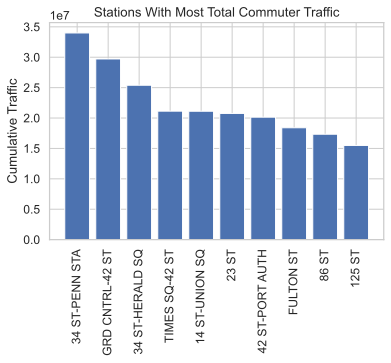

In [44]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['TOTAL_TRAFFIC'][:10])
plt.title('Stations With Most Total Commuter Traffic')
plt.xticks(rotation=90);
plt.ylabel("Cumulative Traffic")
plt.savefig('most_traffic_station.png', dpi=500, bbox_inches='tight');

### Getting top 5 stations Total

In [45]:
station_daily_34_ST_PENN = station_daily[station_daily['STATION'] == '34 ST-PENN STA'].copy()
station_daily_GRD_CENT = station_daily[station_daily['STATION'] == 'GRD CNTRL-42 ST'].copy()
station_daily_HERALD_SQ = station_daily[station_daily['STATION'] == '34 ST-HERALD SQ'].copy()
station_daily_TIMES_SQ = station_daily[station_daily['STATION'] == 'TIMES SQ-42 ST'].copy()
station_daily_UNION_SQ = station_daily[station_daily['STATION'] == '14 ST-UNION SQ'].copy()

station_daily_34_ST_PENN.head()

,STATION,DATE,TOTAL_TRAFFIC
7314,34 ST-PENN STA,2019-03-01,273517.0
7315,34 ST-PENN STA,2019-03-02,153862.0
7316,34 ST-PENN STA,2019-03-03,139369.0
7317,34 ST-PENN STA,2019-03-04,262178.0
7318,34 ST-PENN STA,2019-03-05,341314.0


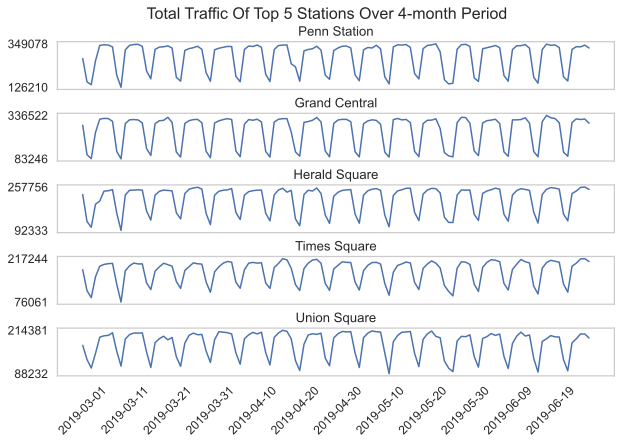

In [46]:
plt.figure(figsize=(10, 6))

plt.suptitle('Total Traffic Of Top 5 Stations Over 4-month Period',fontsize = 16)

plt.subplot(5,1,1)
plt.plot(station_daily_34_ST_PENN['DATE'], station_daily_34_ST_PENN['TOTAL_TRAFFIC'])
plt.title('Penn Station')
plt.xticks([])
plt.yticks([min(station_daily_34_ST_PENN['TOTAL_TRAFFIC']), max(station_daily_34_ST_PENN['TOTAL_TRAFFIC'])])
plt.grid(False)


plt.subplot(5,1,2)
plt.plot(station_daily_GRD_CENT['DATE'], station_daily_GRD_CENT['TOTAL_TRAFFIC'])
plt.title('Grand Central')
plt.xticks([])
plt.yticks([min(station_daily_GRD_CENT['TOTAL_TRAFFIC']), max(station_daily_GRD_CENT['TOTAL_TRAFFIC'])])
plt.grid(False)


plt.subplot(5,1,3)
plt.plot(station_daily_HERALD_SQ['DATE'], station_daily_HERALD_SQ['TOTAL_TRAFFIC'])
plt.title('Herald Square')
plt.xticks([])
plt.yticks([min(station_daily_HERALD_SQ['TOTAL_TRAFFIC']), max(station_daily_HERALD_SQ['TOTAL_TRAFFIC'])])
plt.grid(False)


plt.subplot(5,1,4)
plt.plot(station_daily_TIMES_SQ['DATE'], station_daily_TIMES_SQ['TOTAL_TRAFFIC'])
plt.title('Times Square')
plt.xticks([])
plt.yticks([min(station_daily_TIMES_SQ['TOTAL_TRAFFIC']), max(station_daily_TIMES_SQ['TOTAL_TRAFFIC'])])
plt.grid(False)


plt.subplot(5,1,5)
plt.plot(station_daily_UNION_SQ['DATE'], station_daily_UNION_SQ['TOTAL_TRAFFIC'])
plt.title('Union Square')
plt.xticks(station_daily_UNION_SQ['DATE'][::10] , rotation=45)
plt.yticks([min(station_daily_UNION_SQ['TOTAL_TRAFFIC']), max(station_daily_UNION_SQ['TOTAL_TRAFFIC'])])
plt.grid(False)

plt.subplots_adjust(top=0.9, hspace=0.5)
plt.savefig('traffic_4_month_timeseries.png', dpi=500, bbox_inches='tight');

### Getting Top 5 Stations Daily

In [47]:
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
0,1 AV,2019-03-01,44719.0
1,1 AV,2019-03-02,463.0
2,1 AV,2019-03-03,57.0
3,1 AV,2019-03-04,31433.0
4,1 AV,2019-03-05,42313.0


In [48]:
top_5 = station_totals['STATION'][:5].tolist()

In [49]:
top_5

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ']

In [50]:
station_daily = station_daily[station_daily['STATION'].isin(top_5)]

In [51]:
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
1679,14 ST-UNION SQ,2019-03-01,170285.0
1680,14 ST-UNION SQ,2019-03-02,129605.0
1681,14 ST-UNION SQ,2019-03-03,104628.0
1682,14 ST-UNION SQ,2019-03-04,147185.0
1683,14 ST-UNION SQ,2019-03-05,194211.0


In [52]:
station_daily.STATION.unique()

array(['14 ST-UNION SQ', '34 ST-HERALD SQ', '34 ST-PENN STA',
       'GRD CNTRL-42 ST', 'TIMES SQ-42 ST'], dtype=object)

In [53]:
station_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

In [54]:
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC,DAY_OF_WEEK_NUM
1679,14 ST-UNION SQ,2019-03-01,170285.0,4
1680,14 ST-UNION SQ,2019-03-02,129605.0,5
1681,14 ST-UNION SQ,2019-03-03,104628.0,6
1682,14 ST-UNION SQ,2019-03-04,147185.0,0
1683,14 ST-UNION SQ,2019-03-05,194211.0,1


In [55]:
station_daily_means = station_daily.groupby(['STATION', 'DAY_OF_WEEK_NUM'])[['TOTAL_TRAFFIC']].mean().reset_index()

In [56]:
station_daily_means.rename(columns = {'TOTAL_TRAFFIC': 'MEAN_COMMUTER_TRAFFIC'}, inplace = True)

In [57]:
station_daily_means

,STATION,DAY_OF_WEEK_NUM,MEAN_COMMUTER_TRAFFIC
0,14 ST-UNION SQ,0,177076.294118
1,14 ST-UNION SQ,1,198479.294118
2,14 ST-UNION SQ,2,205947.000000
3,14 ST-UNION SQ,3,202139.235294
4,14 ST-UNION SQ,4,200157.388889
5,14 ST-UNION SQ,5,140644.294118
6,14 ST-UNION SQ,6,105757.705882
7,34 ST-HERALD SQ,0,220258.470588
8,34 ST-HERALD SQ,1,240742.294118
9,34 ST-HERALD SQ,2,248673.352941


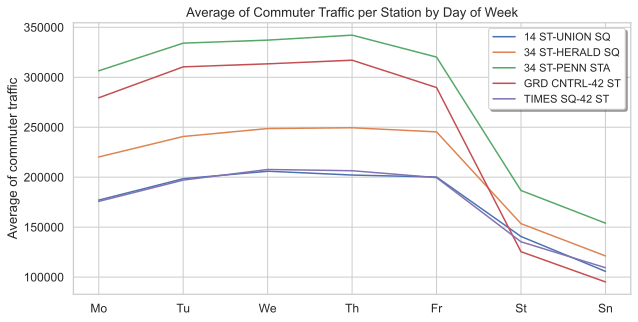

In [58]:
plt.figure(figsize=(10,5))
for i, group in station_daily_means.groupby('STATION'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['MEAN_COMMUTER_TRAFFIC'], label = i)

plt.legend(shadow = True, loc = 0, fontsize = 'small')

plt.ylabel('Average of commuter traffic')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Average of Commuter Traffic per Station by Day of Week')
plt.savefig('mean_per_day.png', dpi=500, bbox_inches='tight');

### Total Traffic value per time of day (for top 5 stations?)

In [59]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00,59.0
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00,435.0
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00,324.0
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00,868.0
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00,322.0


In [60]:
mta_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(mta_daily['DATE']).dt.dayofweek

In [61]:
mta_daily['TIME'] = mta_daily["DATE_TIME"].dt.time

In [62]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,DATE,TIME,TOTAL_TRAFFIC,DAY_OF_WEEK_NUM
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,17.0,42.0,2019-03-01,07:00:00,59.0,4
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,132.0,303.0,2019-03-01,11:00:00,435.0,4
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,259.0,65.0,2019-03-01,15:00:00,324.0,4
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,801.0,67.0,2019-03-01,19:00:00,868.0,4
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,275.0,47.0,2019-03-01,23:00:00,322.0,4


In [63]:
ca_unit_station_hourly = mta_daily.groupby(["C/A", "UNIT", "STATION", "DAY_OF_WEEK_NUM", "TIME"])[['TOTAL_TRAFFIC']].sum().reset_index()

ca_unit_station_hourly.head()

,C/A,UNIT,STATION,DAY_OF_WEEK_NUM,TIME,TOTAL_TRAFFIC
0,A002,R051,59 ST,0,00:00:00,24536.0
1,A002,R051,59 ST,0,03:00:00,289.0
2,A002,R051,59 ST,0,04:00:00,2510.0
3,A002,R051,59 ST,0,07:00:00,604.0
4,A002,R051,59 ST,0,08:00:00,29401.0


In [64]:
station_hourly = mta_daily.groupby(["STATION", "DAY_OF_WEEK_NUM", 'TIME'])[['TOTAL_TRAFFIC']].sum().reset_index()
station_hourly.head()

,STATION,DAY_OF_WEEK_NUM,TIME,TOTAL_TRAFFIC
0,1 AV,0,00:00:00,38608.0
1,1 AV,0,03:00:00,0.0
2,1 AV,0,04:00:00,7293.0
3,1 AV,0,07:00:00,1129.0
4,1 AV,0,07:54:45,2338.0


In [65]:
station_hourly.TIME.describe()

count       181959
unique       71208
top       20:00:00
freq          2487
Name: TIME, dtype: object

In [66]:
station_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181959 entries, 0 to 181958
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATION          181959 non-null  object 
 1   DAY_OF_WEEK_NUM  181959 non-null  int64  
 2   TIME             181959 non-null  object 
 3   TOTAL_TRAFFIC    181959 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.6+ MB


In [67]:
#start = dt.time(0,0)
#end = dt.time(23,59)
#station_hourly.groupby(['STATION', 'DAY_OF_WEEK_NUM' , pd.Grouper(key = "TIME", freq = 'H', axis = 1)])['TOTAL_TRAFFIC'].sum().reset_index()

In [68]:
#Making a time block function to group time column into intervals

In [69]:
def create_time_blocks (row):
    if datetime.time(0,0) <= row['TIME'] < datetime.time(4,0):
        return '00:00 - 04:00'
    elif datetime.time(4,0) <= row['TIME'] < datetime.time(8,0):
        return '04:00 - 08:00'
    elif datetime.time(8,0) <= row['TIME'] < datetime.time(12,0):
        return '08:00 - 12:00'
    elif datetime.time(12,0) <= row['TIME'] < datetime.time(16,0):
        return '12:00 - 16:00'
    elif datetime.time(16,0) <= row['TIME'] < datetime.time(20,0):
        return '16:00 - 20:00'
    elif datetime.time(20,0) <= row['TIME'] <= datetime.time(23, 59):
        return '20:00 - 00:00'
    
station_hourly['TIME_OF_DAY'] = station_hourly.apply(create_time_blocks, axis = 1)

In [70]:
station_hourly.head()

,STATION,DAY_OF_WEEK_NUM,TIME,TOTAL_TRAFFIC,TIME_OF_DAY
0,1 AV,0,00:00:00,38608.0,00:00 - 04:00
1,1 AV,0,03:00:00,0.0,00:00 - 04:00
2,1 AV,0,04:00:00,7293.0,04:00 - 08:00
3,1 AV,0,07:00:00,1129.0,04:00 - 08:00
4,1 AV,0,07:54:45,2338.0,04:00 - 08:00


In [71]:
station_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181959 entries, 0 to 181958
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATION          181959 non-null  object 
 1   DAY_OF_WEEK_NUM  181959 non-null  int64  
 2   TIME             181959 non-null  object 
 3   TOTAL_TRAFFIC    181959 non-null  float64
 4   TIME_OF_DAY      181863 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.9+ MB


In [72]:
station_hourly = station_hourly[station_hourly['STATION'].isin(top_5)]

In [73]:
station_hourly.head()

,STATION,DAY_OF_WEEK_NUM,TIME,TOTAL_TRAFFIC,TIME_OF_DAY
1897,14 ST-UNION SQ,0,00:00:00,10276.0,00:00 - 04:00
1898,14 ST-UNION SQ,0,01:00:00,167688.0,00:00 - 04:00
1899,14 ST-UNION SQ,0,04:00:00,2251.0,04:00 - 08:00
1900,14 ST-UNION SQ,0,05:00:00,21054.0,04:00 - 08:00
1901,14 ST-UNION SQ,0,07:28:40,3613.0,04:00 - 08:00


In [74]:
#check this
station_hourly = station_hourly.groupby(['STATION', 'DAY_OF_WEEK_NUM', 'TIME_OF_DAY'])['TOTAL_TRAFFIC'].sum().reset_index()

In [75]:
station_hourly.head()

,STATION,DAY_OF_WEEK_NUM,TIME_OF_DAY,TOTAL_TRAFFIC
0,14 ST-UNION SQ,0,00:00 - 04:00,177964.0
1,14 ST-UNION SQ,0,04:00 - 08:00,26918.0
2,14 ST-UNION SQ,0,08:00 - 12:00,444851.0
3,14 ST-UNION SQ,0,12:00 - 16:00,648684.0
4,14 ST-UNION SQ,0,16:00 - 20:00,749281.0


In [76]:
station_hourly.sort_values(by = ['STATION', 'DAY_OF_WEEK_NUM','TIME_OF_DAY'])

,STATION,DAY_OF_WEEK_NUM,TIME_OF_DAY,TOTAL_TRAFFIC
0,14 ST-UNION SQ,0,00:00 - 04:00,177964.0
1,14 ST-UNION SQ,0,04:00 - 08:00,26918.0
2,14 ST-UNION SQ,0,08:00 - 12:00,444851.0
3,14 ST-UNION SQ,0,12:00 - 16:00,648684.0
4,14 ST-UNION SQ,0,16:00 - 20:00,749281.0
...,...,...,...,...
205,TIMES SQ-42 ST,6,04:00 - 08:00,125054.0
206,TIMES SQ-42 ST,6,08:00 - 12:00,65742.0
207,TIMES SQ-42 ST,6,12:00 - 16:00,260064.0
208,TIMES SQ-42 ST,6,16:00 - 20:00,453908.0


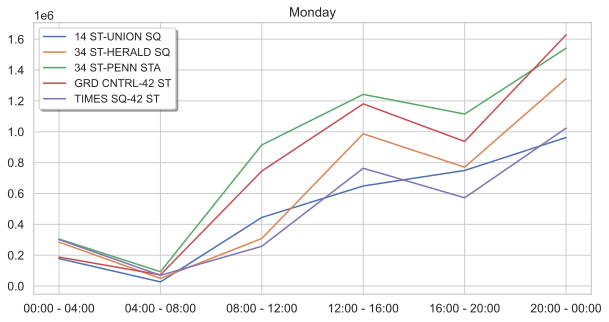

In [77]:
plt.figure(figsize=(10,5))
plt.title("Monday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 0].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Monday_Traffic.png', dpi=500, bbox_inches='tight');

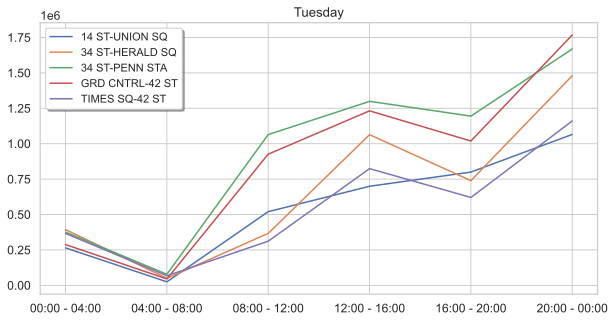

In [78]:
plt.figure(figsize=(10,5))
plt.title("Tuesday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 1].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Tuesday_Traffic.png', dpi=500, bbox_inches='tight');

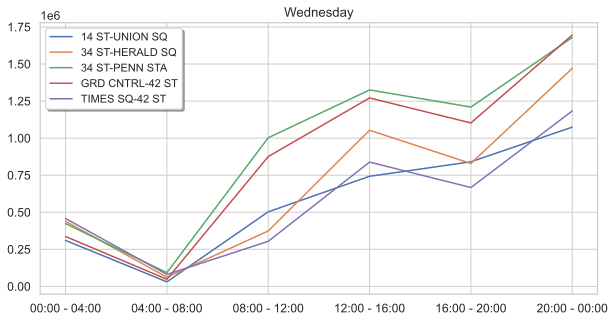

In [79]:
plt.figure(figsize=(10,5))
plt.title("Wednesday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 2].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Wednesday_Traffic.png', dpi=500, bbox_inches='tight');

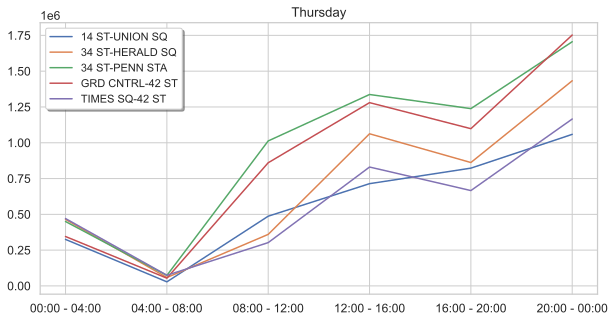

In [80]:
plt.figure(figsize=(10,5))
plt.title("Thursday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 3].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Thursday_Traffic.png', dpi=500, bbox_inches='tight');

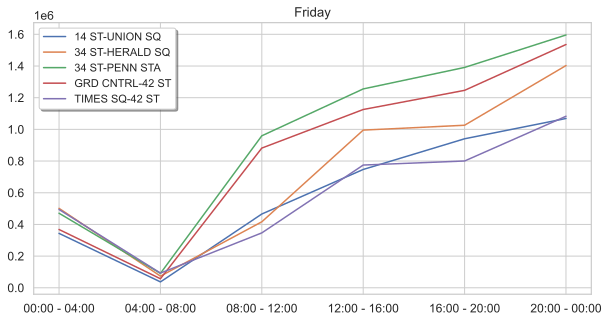

In [81]:
plt.figure(figsize=(10,5))
plt.title("Friday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 4].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Friday_Traffic.png', dpi=500, bbox_inches='tight');

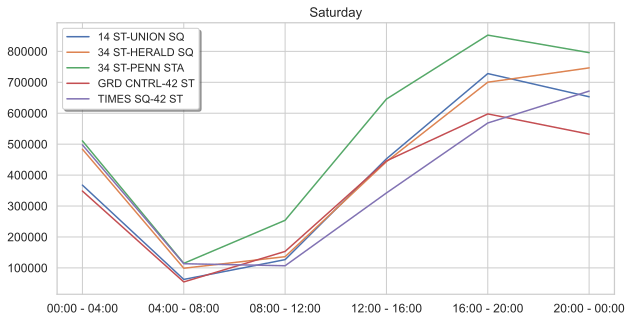

In [82]:
plt.figure(figsize=(10,5))
plt.title("Saturday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 5].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Saturday_Traffic.png', dpi=500, bbox_inches='tight');

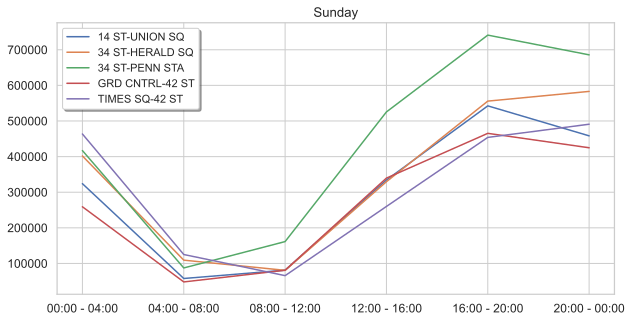

In [83]:
plt.figure(figsize=(10,5))
plt.title("Sunday")
for j, group in station_hourly[station_hourly['DAY_OF_WEEK_NUM'] == 6].groupby('STATION'):
        plt.plot(group['TIME_OF_DAY'], group['TOTAL_TRAFFIC'], label = j) 
        
plt.legend(shadow = True, fontsize = 'small')
plt.xticks(np.arange(6),['00:00 - 04:00','04:00 - 08:00','08:00 - 12:00','12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'])
plt.savefig('Sunday_Traffic.png', dpi=500, bbox_inches='tight');